In [271]:
import pandas as pd
from matplotlib import pyplot as plt
import geopandas as gpd
import numpy as np
from itertools import product
from shapely.geometry import Point, LineString, MultiPoint
from shapely.ops import split, snap
from shapely.affinity import scale
from matplotlib.collections import LineCollection
%matplotlib inline

In [2]:
counties = gpd.read_file('./cb_2016_us_county_500k/cb_2016_us_county_500k.shp')

In [90]:
flow_counts = pd.read_csv('../../../infutor/data/flow_counts.csv', dtype={'PROP_FIPSCD_from': str, 'PROP_FIPSCD_to': str})

In [91]:
flow_counts.head()

,PROP_FIPSCD_from,PROP_FIPSCD_to,count,pct_flow
0,06001,06001,56706,0.144878
1,06001,06013,11045,0.028219
2,06001,06041,524,0.001339
3,06001,06055,189,0.000483
4,06001,06075,1345,0.003436


In [3]:
bayarea = {'Alameda': '001',
           'Contra Costa': '013',
           'Marin': '041',
           'Napa': '055',
           'San Francisco': '075',
           'San Mateo': '081',
           'Santa Clara': '085',
           'Solano': '095',
           'Sonoma': '097'}

In [4]:
mask = (counties['STATEFP'] == '06') & (counties['COUNTYFP'].isin(
    bayarea.values()))
gdf_bay = counties[mask]

In [63]:
gdf_bay.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
55,06,097,01657246,0500000US06097,06097,Sonoma,06,4081437574,497508807,"POLYGON ((-123.533059 38.768424, -123.52851 38..."
434,06,041,00277285,0500000US06041,06041,Marin,06,1348061297,796944835,"(POLYGON ((-122.446316 37.861046, -122.441271 ..."
437,06,055,00277292,0500000US06055,06055,Napa,06,1938165958,104249021,"POLYGON ((-122.646421 38.598593, -122.644696 3..."
441,06,081,00277305,0500000US06081,06081,San Mateo,06,1161658961,757412213,"POLYGON ((-122.520852 37.594178, -122.515326 3..."
442,06,085,00277307,0500000US06085,06085,Santa Clara,06,3344210021,33276429,"POLYGON ((-122.202653 37.363046, -122.201634 3..."


In [64]:
centroids = gdf_bay.copy()

In [65]:
centroids['geometry'] = centroids.centroid

In [469]:
flow_geog = pd.merge(flow_counts, centroids[['GEOID', 'geometry']], left_on='PROP_FIPSCD_from', right_on='GEOID')
flow_geog.rename(columns={'geometry': 'centroid_from'}, inplace=True)
flow_geog.drop(columns=['GEOID'], inplace=True)

In [470]:
flow_geog = pd.merge(flow_geog, centroids[['GEOID', 'geometry']], left_on='PROP_FIPSCD_to', right_on='GEOID')
flow_geog.rename(columns={'geometry': 'centroid_to'}, inplace=True)
flow_geog.drop(columns='GEOID', inplace=True)

In [458]:
flow_geog['geometry'] = None

In [516]:
# parallel offset for every other flow direction
combos = []
geoms = []
for i, row in flow_geog.iterrows():
    if row['PROP_FIPSCD_from'] != row['PROP_FIPSCD_to']:
        line = LineString((row['centroid_from'], row['centroid_to']))
        line = line.parallel_offset(0.025, side='right')
        line = scale(line, 0.8, 0.8)
        geoms.append(line)
    else:
        geoms.append(row['centroid_to'].buffer(0.03).boundary)
#         geoms.append(row['centroid_to'])

flow_geog['geometry'] = geoms
flow_geog = gpd.GeoDataFrame(flow_geog, geometry='geometry')
flow_geog.crs = {'init' :'epsg:4326'}

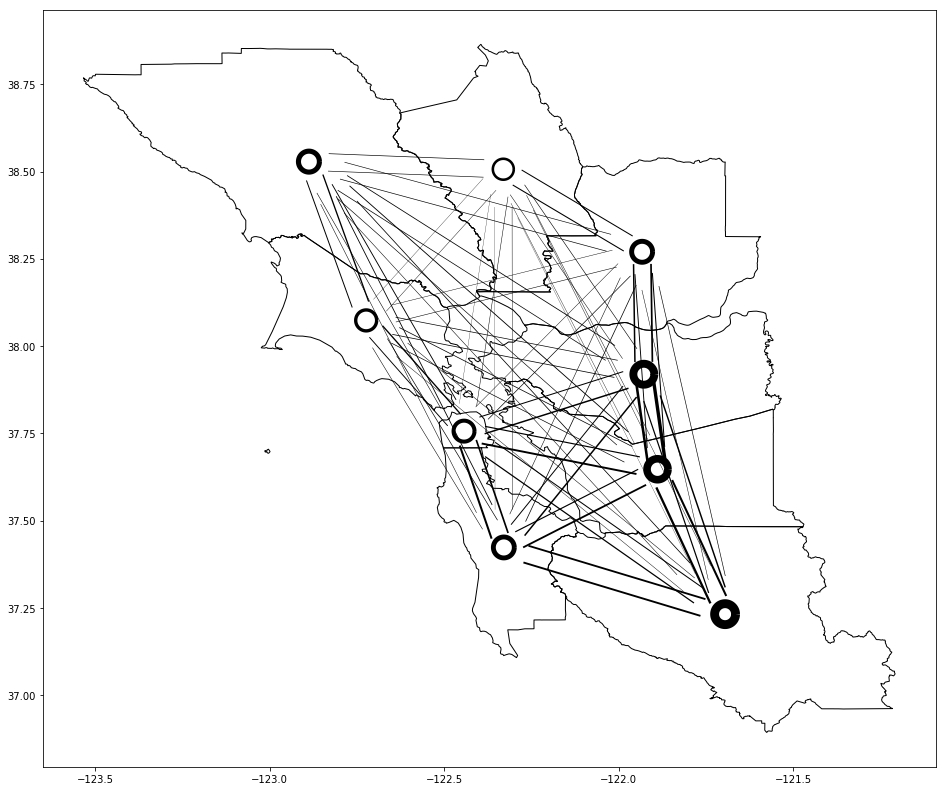

In [526]:
fig, ax = plt.subplots(figsize=(16,16))
gdf_bay.plot(ax=ax, facecolor='None', edgecolor='k')
flow_geog.plot(linewidth=np.sqrt(flow_geog['pct_flow'])*20, ax=ax, edgecolor='k')
# ax.add_collection(lc)
# centroids.plot(ax=ax, c='k', marker='o')

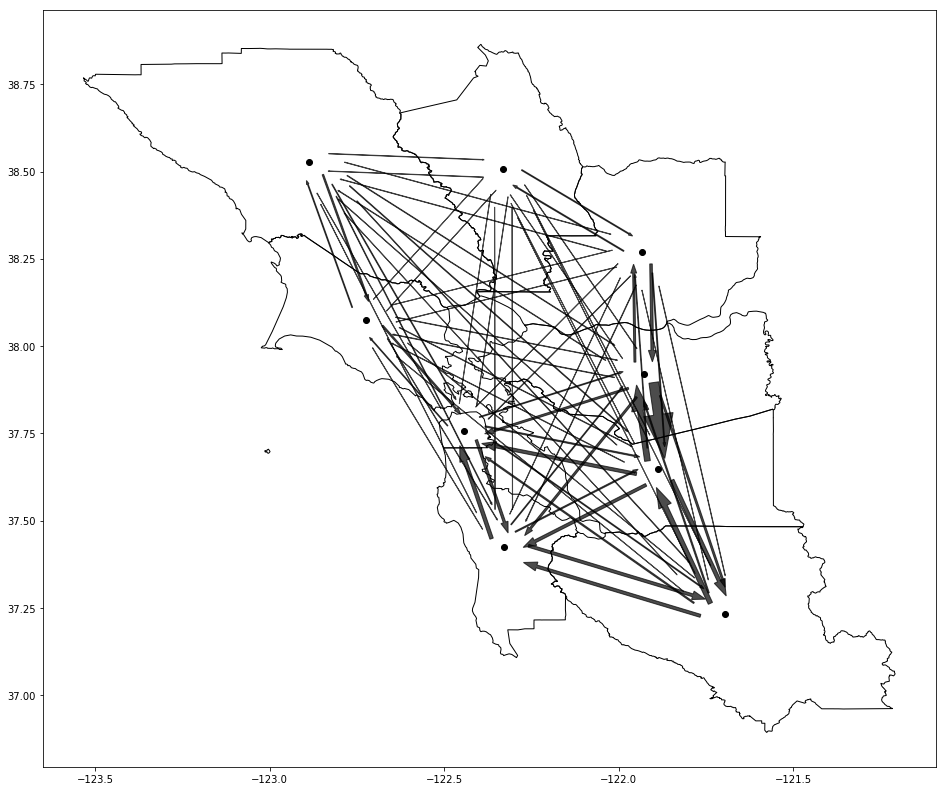

In [534]:
fig, ax = plt.subplots(figsize=(16,16))
gdf_bay.plot(ax=ax, facecolor='None', edgecolor='k')
flow_geog = flow_geog.sort_values('pct_flow')
for i, row in flow_geog.iterrows():
    if row['PROP_FIPSCD_from'] != row['PROP_FIPSCD_to']:
        ax.arrow(
            row['geometry'].coords[0][0],
            row['geometry'].coords[0][1],
            row['geometry'].coords[1][0] - row['geometry'].coords[0][0],
            row['geometry'].coords[1][1] - row['geometry'].coords[0][1],
            width=row['pct_flow'],
            facecolor='k',
            alpha=0.7,
            length_includes_head=True
            
        )
centroids.plot(ax=ax, c='k', marker='o')

### Total Flows

In [572]:
total_counts = flow_counts.copy()

In [573]:
total_counts['sorted_from'] = None
total_counts['sorted_to'] = None

In [574]:
total_counts[['sorted_from', 'sorted_to']] = np.sort(total_counts[[
    'PROP_FIPSCD_from', 'PROP_FIPSCD_to']], 1)

In [575]:
total_counts = total_counts[['sorted_from', 'sorted_to', 'count']].groupby(['sorted_from', 'sorted_to']).sum().reset_index()

In [580]:
total_geog = pd.merge(total_counts, centroids[['GEOID', 'geometry']], left_on='sorted_from', right_on='GEOID')
total_geog.rename(columns={'geometry': 'centroid_from'}, inplace=True)
total_geog.drop(columns=['GEOID'], inplace=True)

In [581]:
total_geog = pd.merge(total_geog, centroids[['GEOID', 'geometry']], left_on='sorted_to', right_on='GEOID')
total_geog.rename(columns={'geometry': 'centroid_to'}, inplace=True)
total_geog.drop(columns='GEOID', inplace=True)

In [584]:
total_geog['geometry'] = None

In [586]:
combos = []
geoms = []
for i, row in total_geog.iterrows():
    if row['sorted_from'] != row['sorted_to']:
        line = LineString((row['centroid_from'], row['centroid_to']))
        line = scale(line, 0.8, 0.8)
        geoms.append(line)
    else:
        geoms.append(row['centroid_to'].buffer(0.03).boundary)

total_geog['geometry'] = geoms
total_geog = gpd.GeoDataFrame(total_geog, geometry='geometry')
total_geog.crs = {'init' :'epsg:4326'}

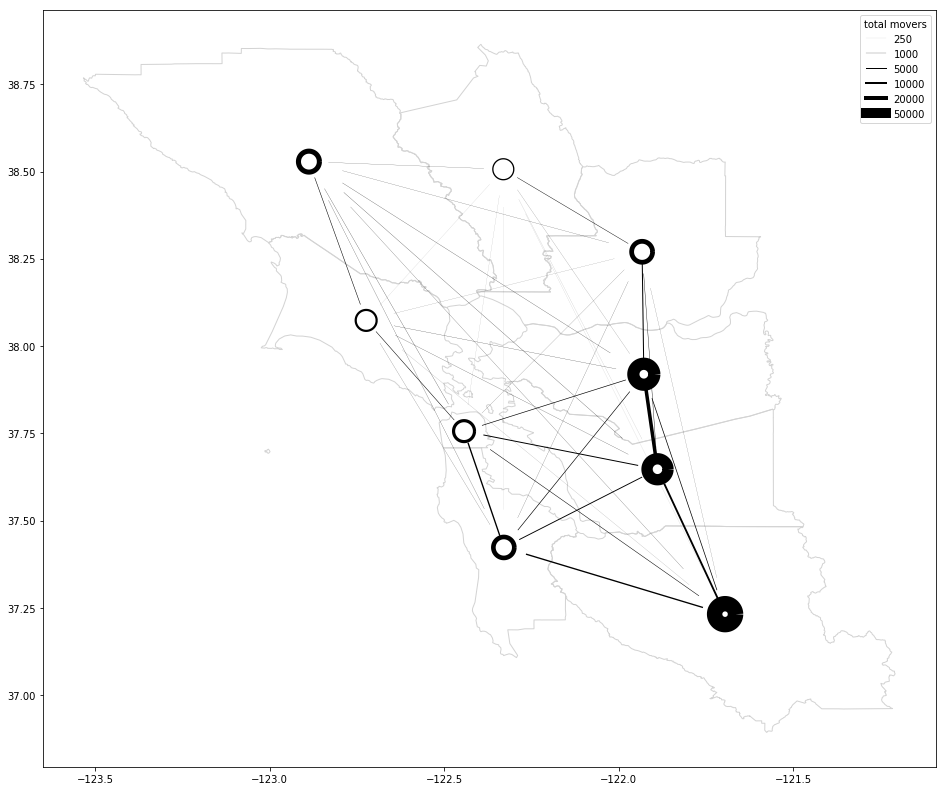

In [622]:
fig, ax = plt.subplots(figsize=(16,16))
gdf_bay.plot(ax=ax, facecolor='None', edgecolor='lightgrey')
total_geog.plot(linewidth=total_geog['count']/5000, ax=ax, edgecolor='k')
for i in [250, 1000, 5000, 10000, 20000, 50000]:
    ax.plot(np.NaN, np.NaN, '-', color='k', label=str(i), linewidth=i/5000)
ax.legend(title='total movers')

### Net Flows

In [554]:
net_counts = flow_counts.copy()

In [557]:
net_counts['sorted_from'] = None
net_counts['sorted_to'] = None

In [558]:
net_counts[['sorted_from', 'sorted_to']] = np.sort(net_counts[[
    'PROP_FIPSCD_from', 'PROP_FIPSCD_to']], 1)

In [560]:
net_counts['net_count'] = net_counts['count']
net_counts.loc[net_counts['PROP_FIPSCD_from'] != net_counts['sorted_from'], 'net_count'] = net_counts.loc[net_counts['PROP_FIPSCD_from'] != net_counts['sorted_from'], 'net_count'] * -1

In [562]:
net_counts = net_counts[['sorted_from', 'sorted_to', 'net_count']].groupby(['sorted_from', 'sorted_to']).sum().reset_index()

In [564]:
net_counts['net_from'] = net_counts['sorted_from']
net_counts['net_to'] = net_counts['sorted_to']
net_counts.loc[net_counts['net_count'] < 0, 'net_from'] = net_counts.loc[net_counts['net_count'] < 0, 'sorted_to']
net_counts.loc[net_counts['net_count'] < 0, 'net_to'] = net_counts.loc[net_counts['net_count'] < 0, 'sorted_from']

In [566]:
net_counts = net_counts[['net_from', 'net_to', 'net_count']]

In [567]:
net_counts['net_count'] = np.abs(net_counts['net_count'])

/home/max/anaconda3/envs/infutor/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [740]:
net_geog = pd.merge(net_counts, centroids[['GEOID', 'geometry']], left_on='net_from', right_on='GEOID')
net_geog.rename(columns={'geometry': 'centroid_from'}, inplace=True)
net_geog.drop(columns=['GEOID'], inplace=True)

In [741]:
net_geog = pd.merge(net_geog, centroids[['GEOID', 'geometry']], left_on='net_to', right_on='GEOID')
net_geog.rename(columns={'geometry': 'centroid_to'}, inplace=True)
net_geog.drop(columns='GEOID', inplace=True)

In [742]:
combos = []
geoms = []
for i, row in net_geog.iterrows():
    if row['net_from'] != row['net_to']:
        line = LineString((row['centroid_from'], row['centroid_to']))
        geoms.append(line)
    else:
        geoms.append(row['centroid_to'].buffer(0.03).boundary)

net_geog['geometry'] = geoms
net_geog = gpd.GeoDataFrame(net_geog, geometry='geometry')
net_geog.crs = {'init' :'epsg:4326'}

In [743]:
def proportional_scale(linestring, max_length, scale_factor):
    loss = max_length - max_length * scale_factor
    proportional_factor = 1 - loss/linestring.length
    scaled_linestring = scale(linestring, proportional_factor, proportional_factor)
    return scaled_linestring
    

In [744]:
net_geog['geometry'] = net_geog['geometry'].apply(proportional_scale, args=(net_geog['geometry'].length.min(), 0.5))

Text(0.5, 1.0, 'Net Movers')

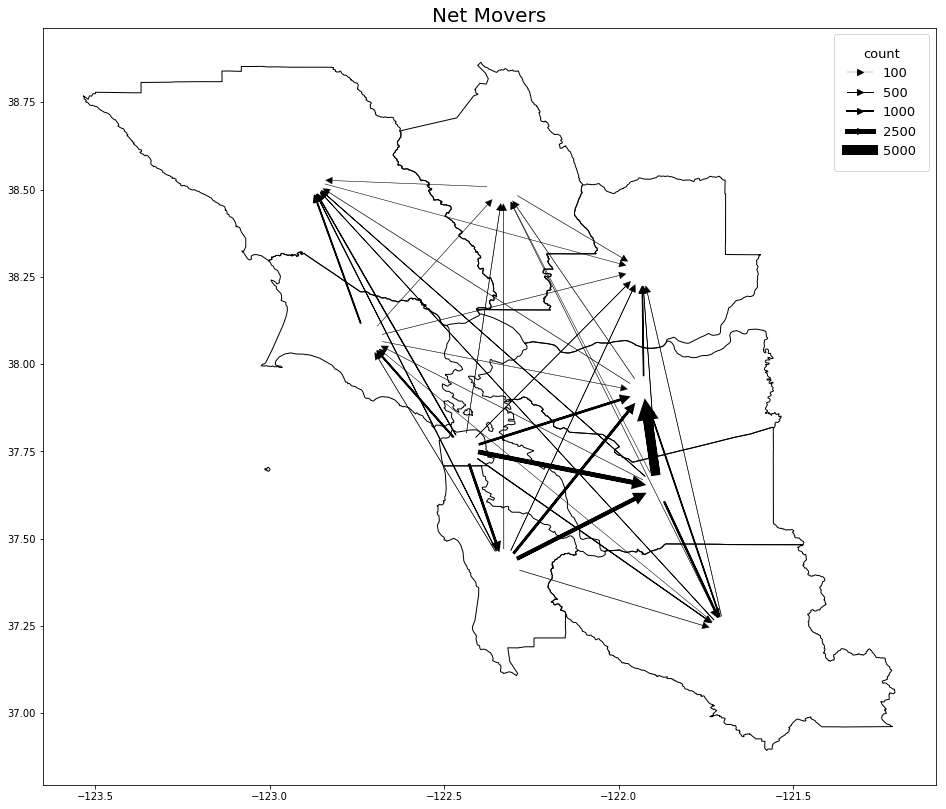

In [745]:
fig, ax = plt.subplots(figsize=(16,16))
gdf_bay.plot(ax=ax, facecolor='None', edgecolor='k')
arrows = []
legend_labels = []
for i, row in net_geog.iterrows():
    if row['net_from'] != row['net_to']:
        arrow = ax.arrow(
            row['geometry'].coords[0][0],
            row['geometry'].coords[0][1],
            row['geometry'].coords[1][0] - row['geometry'].coords[0][0],
            row['geometry'].coords[1][1] - row['geometry'].coords[0][1],
#             width=row['net_count']/150000,
            linewidth=row['net_count']/500,
            head_length=0.02,
            head_width=0.02,
            facecolor='k',
            length_includes_head=True,
        )
        arrows.append(arrow)
        legend_labels.append(row['net_count'])
for i in [100, 500, 1000, 2500, 5000]:
    ax.plot(np.NaN, np.NaN, '->', color='k', label=str(i), linewidth=i/500)
# centroids.plot(ax=ax, c='k', marker='o')
ax.legend(title='count', fontsize=13, borderpad=1, title_fontsize=13)
ax.set_title('Net Movers', fontsize=20)